In [1]:
import sys
sys.path.append("/u/home/a/alejandr/bin")
sys.path.append("/u/home/x/xiyuyi/bin")
sys.path.append("G:\\DH_localization\\PyPRIS")
from PyPRIS import *
import os
print("")
print("")
print("")
import warnings
warnings.filterwarnings("ignore")

In [2]:
obj_fpath = 'G:\\DH_localization\\PyPRIS_CL_set1\\bgSCF12_mu1.0e+08_alpha1.0e-05_thres-17zrange-19to19_chosen\\saved_objects'
linbreg_fpath = obj_fpath+'\\PyPRIS_bgSCF12_mu1.0e+08_alpha1.0e-05_thres-17zrange-19to19_pris6_80000.file'
pypris_fpath = obj_fpath+'\\PyPRIS_pris6.file'

'''

load the linbreg object from the 0th order result

'''

with open(linbreg_fpath,'rb') as f:
    linb0 = pickle.load(f)

with open(pypris_fpath,'rb') as f:
    pypris0 = pickle.load(f)


In [3]:
# prepare a field shift observer
psf_path = 'G:\\DH_localization\\PyPRIS\\test_dataset_5\\psf_cropped_1st.tif'
img_1st_order_path = 'G:\\DH_localization\\PyPRIS\\test_dataset_5\\combined_1st.tif'
psf = io.imread(psf_path)
wshift_1stdiff = io.imread(img_1st_order_path)

observer = ObserveStation()
observer.observe_with_shift_prep(psf, single_image_size=[140,100], psfz0=35,
                                      shift_1=0, shift_2=0,
                                      observer_debugger=False, observer_edge_padding=True)

pypris0.observe = copy.deepcopy(observer.observe_with_shift)
pypris0.generate_sensing_mx()

----------- Generate sensing matrix:
            Matrix size: 14000  observation pixels 
                         91480  candidates 


In [4]:
# remove some background
filtered_x = copy.deepcopy(linb0.x)
for ind, m in enumerate(filtered_x):
    if m < 5:
        filtered_x[ind] = 0

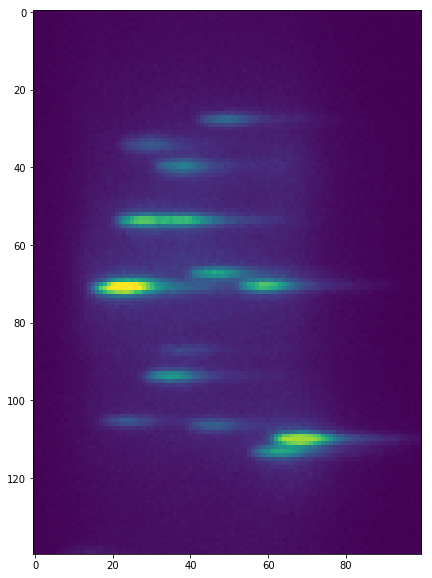

In [5]:
# shift free image
woshift_1stdiff = np.dot(pypris0.current_A, filtered_x).reshape(140,100)
plt.figure(figsize=(10,10))
plt.imshow(wshift_1stdiff)

In [6]:
from scipy import signal
from scipy import misc
a = wshift_1stdiff/np.max(wshift_1stdiff.ravel())
b = woshift_1stdiff/np.max(woshift_1stdiff.ravel())
corr = signal.correlate2d(a, b, boundary='fill', mode='same')
fitted_shift_1, fitted_shift_2 = np.unravel_index(np.argmax(corr), corr.shape) # find the match
print(y, x)

NameError: name 'y' is not defined

In [ ]:
plt.figure(figsize=[10,5])
plt.subplot(131)
plt.imshow(corr)
plt.subplot(132)
plt.imshow(a - b)

In [ ]:

plt.imshow(a - b)

In [ ]:
# now incorporate such shift into the obesrver, and check with difference image.
observer = ObserveStation()
observer.observe_with_shift_prep(psf, single_image_size=[140,100], psfz0=35,
                                      shift_1=fitted_shift_1-140/2, shift_2 = fitted_shift_2-50,
                                      observer_debugger=False, observer_edge_padding=True)

pypris_incshift = copy.deepcopy(pypris0)
pypris_incshift.observe = copy.deepcopy(observer.observe_with_shift)
pypris_incshift.generate_sensing_mx()

In [ ]:
incshift_1stdiff = np.dot(pypris_incshift.current_A, filtered_x).reshape(140,100)
a = wshift_1stdiff/np.max(wshift_1stdiff.ravel())
b = woshift_1stdiff/np.max(woshift_1stdiff.ravel())
c = incshift_1stdiff/np.max(incshift_1stdiff.ravel())


In [ ]:
plt.figure(figsize=[5,10])
plt.subplot(131)
plt.imshow(a-b)
plt.subplot(132)
plt.imshow(a-c)
plt.subplot(133)
plt.imshow(b-c)
